In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer, GlobalMaxPooling2D
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')


#Constructing the DataFrame for the Flickr30k and Flickr8k dataset: Each image in these dataset is associated with 5 distinct captions. DataFrames are structured for these datasets with two columns: one for the image addresses and one for the captions. For every image, there are five rows, each containing a different caption corresponding to that image. Then we combined these two dataframes.

##Reading Flickr30k dataset


In [2]:
path_30 = "flickr30k_images/"
image_path_30 = path_30 + "Images/"

data = pd.read_csv(path_30 + "results.csv")
data = data['image_name| comment_number| comment']


data_list = []
for i in data:
    img_name, _, caption = i.split("| ")
    data_list.append({'image': image_path_30 + img_name, 'caption': caption})

# Convert the list to a DataFrame in one step
data_30k = pd.DataFrame(data_list)

##Reading flickr8k dataset

In [3]:
path_8 = 'flickr8k_images/'
image_path_8 = path_8 + "Images/"

data_8k = pd.read_csv(path_8 + "captions.txt")

data_8k['image'] = image_path_8 + data_8k['image']

##Merging two datasets

In [4]:
data = pd.concat([data_8k, data_30k], ignore_index=True)

In [5]:
data

,image,caption
0,flickr8k_images/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,flickr8k_images/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,flickr8k_images/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,flickr8k_images/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,flickr8k_images/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
199365,flickr30k_images/Images/998845445.jpg,A man in shorts and a Hawaiian shirt leans ove...
199366,flickr30k_images/Images/998845445.jpg,A young man hanging over the side of a boat
199367,flickr30k_images/Images/998845445.jpg,A man is leaning off of the side of a blue and...
199368,flickr30k_images/Images/998845445.jpg,A man riding a small boat in a harbor


##Displays images

In [6]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(temp_df.image[i])
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

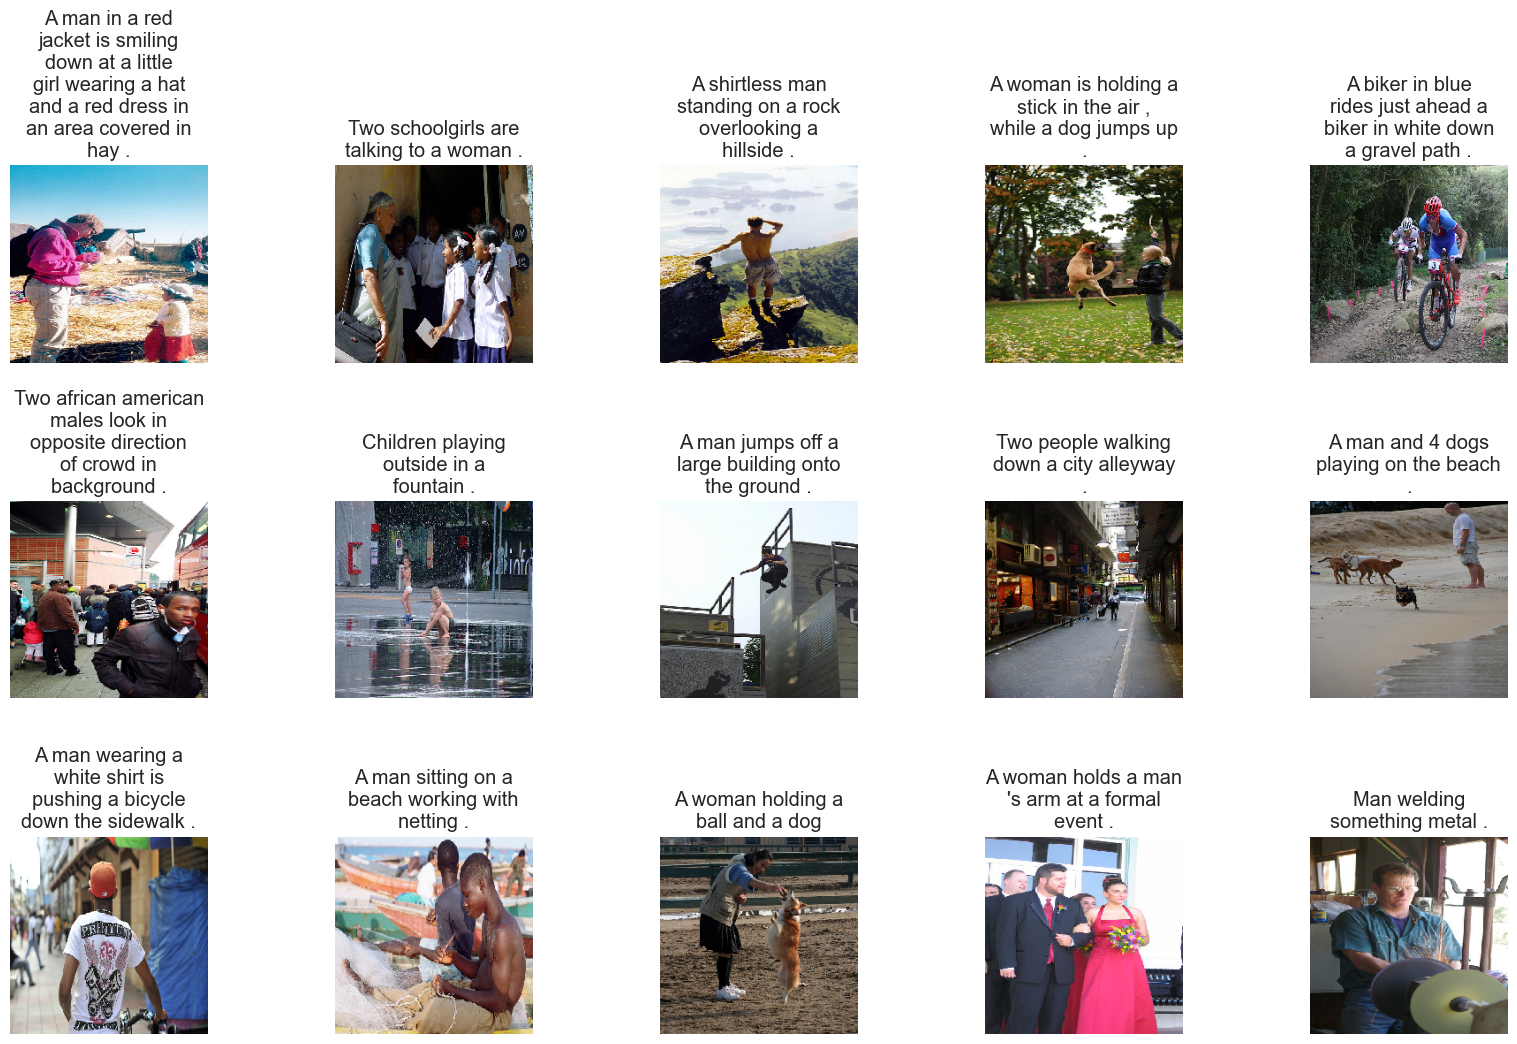

In [10]:
display_images(data.sample(15))

In [7]:
import string

# Initialize an empty list to store processed captions
processed_captions = []

def caption_preprocess(data):
    """
    Preprocesses captions by converting them to lowercase, removing punctuation,
    and filtering out single-character words. Each modified caption is then
    wrapped with 'startseq' and 'endseq' to denote the beginning and end of the sequence.

    Args:
    data (dict): A dictionary containing a key 'caption' which maps to a list of caption strings.

    Returns:
    dict: The input dictionary with the 'caption' list replaced by the processed captions.
    """
    # Iterate over each caption in the data
    for sentences in data['caption']:
        # Convert the caption to lowercase
        lower_sentences = sentences.lower()
        # Remove punctuation using a translation table
        no_punc = lower_sentences.translate(str.maketrans('', '', string.punctuation))
        # Filter out single-character words and rebuild the sentence
        sentence = ' '.join([char for char in no_punc.split() if len(char) > 1])
        # Append 'startseq' at the beginning and 'endseq' at the end of the sentence
        new_sentence = 'startseq ' + sentence + ' endseq'
        # Add the new sentence to the list of processed captions
        processed_captions.append(new_sentence)
    # Update the 'caption' key in the dictionary to hold the processed captions
    data['caption'] = processed_captions
    return data

# Process the captions in the dataset
data = caption_preprocess(data)
# Convert the list of processed captions back to a list and store in 'captions'
captions = data['caption'].tolist()


In [12]:
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [8]:
from keras.preprocessing.text import Tokenizer

# Initialize the tokenizer
tokenizer = Tokenizer()
# Fit the tokenizer on the captions to build the vocabulary
tokenizer.fit_on_texts(captions)

# Calculate the size of the vocabulary used in the captions
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

# Determine the maximum length of captions in the dataset
max_length = max(len(caption.split()) for caption in captions)
print("Maximum caption length:", max_length)

# Extract a list of unique image addresses from the dataset
images = data['image'].unique().tolist()
# Count the total number of unique images
nimages = len(images)
print("Number of unique images:", nimages)

# Determine the split index for training and validation sets (85% training, 15% validation)
split_index = round(0.85 * nimages)
# Create image lists for training and validation datasets
train_images = images[:split_index]
val_images = images[split_index:]

# Filter the data to create the training set from the training images
train = data[data['image'].isin(train_images)]
# Filter the data to create the validation set from the validation images
test = data[data['image'].isin(val_images)]

# Reset the index of the training and validation dataframes for clean data handling
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
print("Train size : ",train.shape)
print("Test size : ",test.shape)

Vocabulary size: 19041
Maximum caption length: 70
Number of unique images: 39874
Train size :  (169465, 2)
Test size :  (29905, 2)


#Feature extraction from images using VGG16

In [9]:
import numpy as np
import pickle
from keras.applications import VGG16
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

# Define the path and load the VGG16 model
#conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Set image size and initialize the features dictionary
#img_size = 240
#batch_size = 32  # Define batch size that fits your memory
#features = {}

# Get unique images
#unique_images = data['image'].unique().tolist()
#total_images = len(unique_images)
#batches = (total_images + batch_size - 1) // batch_size  # Calculate number of batches

# Process images in batches
#for i in tqdm(range(batches)):
#    batch_images = unique_images[i * batch_size:(i + 1) * batch_size]
#    batch_imgs = [img_to_array(load_img(img, target_size=(img_size, img_size))) for img in batch_images]
#    batch_imgs = np.array(batch_imgs) / 255.0  # Normalize images
#    batch_imgs = np.vstack([np.expand_dims(img, axis=0) for img in batch_imgs])  # Prepare batch for processing

    # Generate features using VGG16 model
#    batch_features = conv_base.predict(batch_imgs, verbose=0)

    # Map features to corresponding images
#    for img_path, feature in zip(batch_images, batch_features):
#        features[img_path] = feature

# Save the features to a pickle file
#with open('VGG16_features.pickle', 'wb') as handle:
#    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

##Load VGG16 features

In [10]:
with open('VGG16_features.pickle', 'rb') as handle:
    features = pickle.load(handle) #load features

In [16]:
len(features)

39874

# CustomDataGenerator (__getdata) explanation:

It begins by retrieving precomputed CNN features for each image in the batch, aligning these with their respective captions. These features encapsulate the visual content of the images. Sequence Processing: Tokenization: Each caption is converted into a sequence of integers using a tokenizer, where each integer corresponds to a word in the tokenizer's vocabulary. Sequence Creation: The function generates input and output sequences for each caption. The input sequences are constructed by incrementally including words from the start of the caption up to the current word, training the model to predict the next word based on previous words. Preparation: The input sequences are padded to ensure they are of uniform length, and the output words are converted into one-hot encoded vectors to fit the model's output format. Batch Output: Arrays for image features (X1), caption sequences (X2), and target output vectors (y) are compiled into batches. These arrays are used as the input and output data in model training.

In [20]:
conda install keras

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-arm64::jupyter_core==5.3.0=py310hca03da5_0
  - defaults/osx-arm64::nbformat==5.7.0=py310hca03da5_0
  - defaults/osx-arm64::sip==6.6.2=py310hc377ac9_0
  - defaults/osx-arm64::jupyter_console==6.6.3=py310hca03da5_0
  - defaults/osx-arm64::notebook==6.5.4=py310hca03da5_0
  - defaults/osx-arm64::jupyterlab_server==2.22.0=py310hca03da5_0
  - defaults/osx-arm64::jupyter_server==1.23.4=py310hca03da5_0
  - defaults/osx-arm64::pyqt5-sip==12.11.0=py310hc377ac9_0
  - defaults/osx-arm64::notebook-shim==0.2.2=py310hca03da5_0
  - defaults/osx-arm64::jupyterlab==3.5.3=py310hca03da5_0
  - defaults/osx-arm64::nbconvert==6.5.4=py310hca03da5_0
  - defaults/osx-arm64::comm==0.1.2=py310hca03da5_0
  - defaults/noarch::prompt_toolkit==3.0.36=hd3eb1b0_0
  - defaults/noarch::bleach==4.1.0=pyhd3eb1b0_0
  - defaults/osx-arm64::matplotlib-inline==

In [23]:
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import numpy as np

class CustomDataGenerator(Sequence):
    """
    Custom data generator class inheriting from Keras' Sequence, to be used for generating data batches
    during model training, particularly for image-caption paired data.

    Attributes:
    df (DataFrame): DataFrame containing the dataset.
    X_col (str): Column name in df for input images.
    y_col (str): Column name in df for output captions.
    batch_size (int): Number of samples per batch.
    directory (str): Directory path where image files are stored.
    tokenizer (Tokenizer): Tokenizer for processing text captions.
    vocab_size (int): The size of the vocabulary.
    max_length (int): The maximum length of captions.
    features (dict): Pre-computed feature maps for images.
    shuffle (bool): Whether to shuffle the data at the end of each epoch.
    """
    def __init__(self, df, X_col, y_col, batch_size, tokenizer,
                 vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)  # Total number of samples

    def on_epoch_end(self):
        """
        Shuffles the DataFrame if 'shuffle' is True. This method is automatically called
        at the end of each epoch if using Keras' fit_generator.
        """
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        """
        Denotes the number of batches per epoch.

        Returns:
        int: The number of batches per epoch.
        """
        return self.n // self.batch_size

    def __getitem__(self, index):
        """
        Generate one batch of data.

        Args:
        index (int): Index of the batch.

        Returns:
        tuple: Tuple containing two elements (inputs, outputs) for the model.
        """
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        """
        Generates data containing batch_size samples. This is a private method used internally.

        Args:
        batch (DataFrame): The portion of the DataFrame corresponding to one batch.

        Returns:
        tuple: Tuple containing arrays for the inputs and outputs for the model.
        """
        X1, X2, y = [], [], []

        images = batch[self.X_col].tolist()

        for image in images:
            # Retrieve the pre-computed feature for each image
            feature = self.features['/content/drive/MyDrive/Colab Notebooks/CSE 5717 project/'+image].reshape((7,7,512))

            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y


In [24]:
from keras.layers import Input, Flatten, Dense, Reshape, Embedding, concatenate, LSTM, add, Dropout
from keras.models import Model

# Define input layers for the model
input1 = Input(shape=(7,7,512))  # Input layer for image features with dimensions matching the output of a CNN
input2 = Input(shape=(max_length,))  # Input layer for captions represented as sequences of integers

# Flatten the 3D output of a CNN to a 1D vector to process image features
x = Flatten()(input1)
# Dense layer to reduce dimensionality and introduce non-linearity for image features
img_features = Dense(256, activation='relu')(x)
# Reshape image features to be compatible for concatenation with sentence features
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# Embedding layer to convert caption indices into dense vectors of fixed size
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
# Concatenate image and sentence features along the time dimension
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

# Process the combined features with a bidirectional LSTM to capture context from both directions
sentence_features = Bidirectional(LSTM(128, return_sequences=False))(merged)

# Additional Dense layer for further processing the image features
img_features = Dense(256, activation='relu')(img_features)
# Element-wise addition of the outputs from the previous layers to integrate image and text features
x = add([sentence_features, img_features])
# Further dense layers to refine the features into a more abstract representation
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
# Dropout layer to prevent overfitting
x = Dropout(0.1)(x)
# Output layer with a softmax activation to output probabilities for the vocabulary
output = Dense(vocab_size, activation='softmax')(x)

# Define the model with input and output specifications
caption_model = Model(inputs=[input1, input2], outputs=output)
# Compile the model with loss and optimizer settings suitable for a classification problem
caption_model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


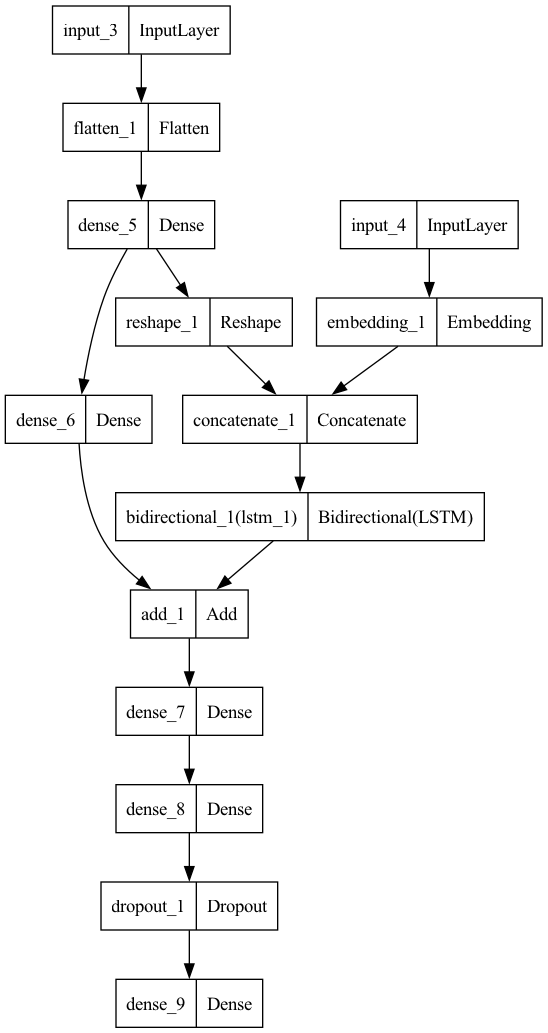

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [26]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 7, 7, 512)]          0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 25088)                0         ['input_3[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 256)                  6422784   ['flatten_1[0][0]']           
                                                                                                  
 input_4 (InputLayer)        [(None, 70)]                 0         []                            
                                                                                            

In [28]:
image_path = '/content/drive/MyDrive/Colab Notebooks/CSE 5717 project/'
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [29]:
validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
#model_name = "VGG16_extracted_model2.h5"
#checkpoint = ModelCheckpoint(model_name,
#                            monitor="val_loss",
#                            mode="min",
#                            save_best_only = True,
#                            verbose=1)

#earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

#learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
#                                            patience=20,
#                                            verbose=1,
#                                            factor=0.2,
#                                            min_lr=0.00000001)


In [ ]:
#history = caption_model.fit(
#        train_generator,
#        epochs=50,
#        validation_data=validation_generator,
#        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
2647/2647 [==============================] - ETA: 0s - loss: 4.7359 - accuracy: 0.2196
Epoch 1: val_loss improved from inf to 4.71438, saving model to VGG16_extracted_model2.h5
2647/2647 [==============================] - 2100s 791ms/step - loss: 4.7359 - accuracy: 0.2196 - val_loss: 4.7144 - val_accuracy: 0.2312 - lr: 0.0010
Epoch 2/50
2647/2647 [==============================] - ETA: 0s - loss: 4.1825 - accuracy: 0.2712
Epoch 2: val_loss improved from 4.71438 to 4.52110, saving model to VGG16_extracted_model2.h5
2647/2647 [==============================] - 572s 216ms/step - loss: 4.1825 - accuracy: 0.2712 - val_loss: 4.5211 - val_accuracy: 0.2530 - lr: 0.0010
Epoch 3/50
2647/2647 [==============================] - ETA: 0s - loss: 4.0431 - accuracy: 0.2861
Epoch 3: val_loss improved from 4.52110 to 4.45045, saving model to VGG16_extracted_model2.h5
2647/2647 [==============================] - 615s 232ms/step - loss: 4.0431 - accuracy: 0.2861 - val_loss: 4.4504 - val_accurac

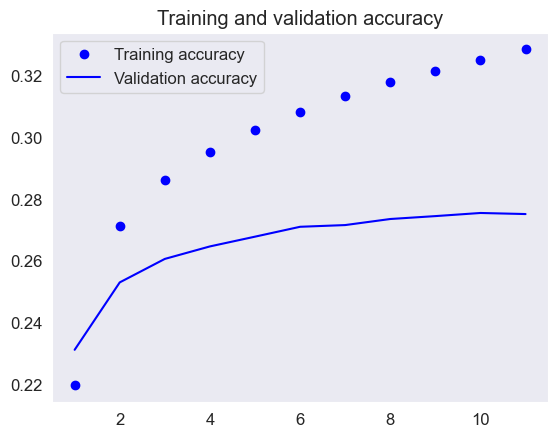

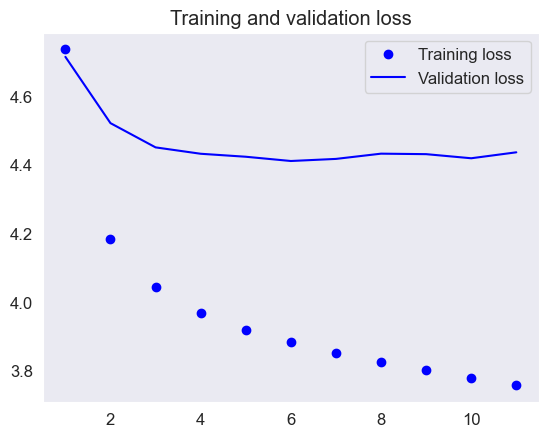

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [30]:
from nltk.translate.bleu_score import sentence_bleu
caption_model = tf.keras.models.load_model("VGG16_extracted_model.h5")


def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length, features):


    feature = features['/content/drive/MyDrive/Colab Notebooks/CSE 5717 project/'+image].reshape((-1,7,7,512))

    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text


def remover (li):
    lin = []

    for i in range(len(li)):
        li[i] = li[i].replace('startseq','')
        li[i] = li[i].replace('endseq','')
        lin.append(li[i])
    return lin


def evaluate (df):
    score = []
    for index,record in df.iterrows():
        img = load_img(record['image'],target_size=(224,224))
        img = img_to_array(img)
        img = img/255.

        caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)


        true_caption = remover(list(df.loc[df['image'] == record['image'], 'caption']))


        predicted_caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
        predicted_caption = predicted_caption.replace('startseq','')
        predicted_caption = predicted_caption.replace('endseq','')

        score.append(sentence_bleu(true_caption, predicted_caption))

    return score

1/1 [==============================] - 0s 47ms/step
[['man', 'in', 'plaid', 'stops', 'to', 'take', 'picture', 'while', 'man', 'in', 'blue', 'looks', 'off', 'at', 'something', 'else'], ['man', 'wearing', 'blue', 'sweater', 'and', 'tan', 'sock', 'hat', 'is', 'smoking', 'cigarette'], ['two', 'people', 'on', 'city', 'street', 'looking', 'up', 'into', 'the', 'night', 'sky'], ['two', 'men', 'standing', 'in', 'busy', 'city', 'while', 'one', 'takes', 'photo'], ['man', 'in', 'blue', 'jacket', 'is', 'looking', 'up', 'at', 'something']]
['man', 'in', 'black', 'shirt', 'and', 'blue', 'pants', 'is', 'sitting', 'on', 'bench']
Score is : 7.208781414766327e-155


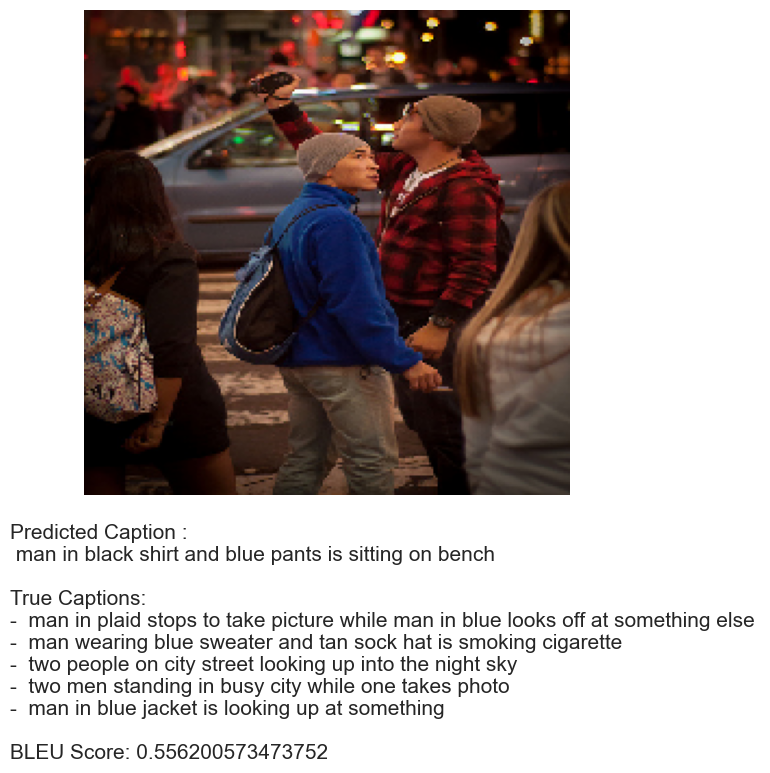

In [31]:
def display_generated_image(n):

    # Load and preprocess the image
    img = load_img(test['image'][n], target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.



    # Read the actual size image for display
    true_caption = remover(list(test.loc[test['image'] == test['image'][n], 'caption']))


    predicted_caption = predict_caption(caption_model, test['image'][n], tokenizer, max_length, features)
    predicted_caption = predicted_caption.replace('startseq','')
    predicted_caption = predicted_caption.replace('endseq','')
    true_cap = []
    for i in range(len(true_caption)):
        true_cap.append(true_caption[i].split())
    print(true_cap)
    print(predicted_caption.split())
    print("Score is :" , sentence_bleu(true_cap,predicted_caption.split()))

    score = sentence_bleu(true_caption, predicted_caption)
    image = readImage(test['image'][n])

    # Create a figure with two subplots: one for the image and one for the text
    # The first subplot (for the image) is larger to prevent overlap
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 8))

    # Display the image on the first subplot
    ax1.imshow(img)
    ax1.axis('off')  # Hide the axis for the image subplot

    # Remove the second subplot's axes as we will use it for text
    ax2.axis('off')

    # Prepare the caption and BLEU score text
    caption_text = (f"Predicted Caption :\n{predicted_caption}\n\n" +
                    "True Captions:\n" + "\n".join(["- " + cap for cap in true_caption]) + "\n\n" +
                    f"BLEU Score: {score}")

    # Place the text in the second subplot
    ax2.text(0, 0.5, caption_text, ha='left', va='center', fontsize=15)

    # Adjust layout to make room for all content
    fig.tight_layout()

    # Show the plot
    plt.show()

display_generated_image(100)